In [44]:
# Load all necessary packages
import sys
sys.path.insert(1, "../")  

import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt

import pandas as pd
import sklearn
from aif360.datasets import GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from IPython.display import Markdown, display

In [4]:
data = pd.read_csv("./data.csv")
data.head(10)

,Num_Children,Group,Income,Own_Car,Own_Housing,Target
0,4,0,36151,0,0,0
1,0,0,36095,1,0,0
2,2,1,62110,1,1,0
3,0,1,73644,1,0,0
4,3,0,99146,0,0,1
5,0,1,114086,1,0,1
6,2,0,37055,1,0,0
7,2,1,83130,1,1,1
8,2,1,81965,1,0,1
9,3,0,35094,1,0,0


In [5]:
target_column = "Target"

In [6]:
X = data.loc[:, data.columns != target_column]
X.head(5)

,Num_Children,Group,Income,Own_Car,Own_Housing
0,4,0,36151,0,0
1,0,0,36095,1,0
2,2,1,62110,1,1
3,0,1,73644,1,0
4,3,0,99146,0,0


In [7]:
y = data.loc[:, data.columns == target_column]
y.head(5)

,Target
0,0
1,0
2,0
3,0
4,1


In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

### 1. SVM

In [ ]:
from sklearn import svm
clf = svm.SVC(verbose=1)
clf.fit(X_train, y_train.values.ravel())

[LibSVM].....

### 2. k-Nearest Neighbors

In [22]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train.values.ravel());

In [23]:
y_pred = clf.predict(X_test)

In [28]:
print(confusion_matrix(y_test,y_pred))

[[58107  3120]
 [ 3371 35402]]


In [27]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     61227
           1       0.92      0.91      0.92     38773

    accuracy                           0.94    100000
   macro avg       0.93      0.93      0.93    100000
weighted avg       0.94      0.94      0.94    100000



In [33]:
error_rate = []

for i in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    error_rate.append(np.mean(y_pred != y_test))

Text(0, 0.5, 'Error Rate')

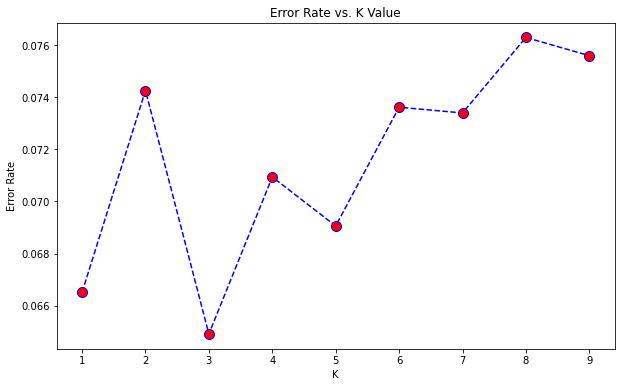

In [49]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10),error_rate,color='blue', linestyle='dashed', marker='o',
 markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
# NOW WITH K=20
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print(confusion_matrix(y_test,pred))

print(classification_report(y_test,pred))